МФТИ: Data Mining in Action (осень, 2016)
- Арсений Ашуха, ars.ashuha@gmail.com, https://vk.com/ars.ashuha
- Дмитрий Персиянов, https://vk.com/persiyanov

<h1 align="center">MNIST Autoencoder</h1> 

Мы хотим сжимать большие вектора (ч/б картинку размером 28x28 можно вытянуть в вектор длины 784) в маленькие так, чтобы уметь хорошо восстанавливать большие вектора. Одна из самых простых моделей -- полносвязный автоэнкодер. Мы применяем к вектору линейные преобразования (умножаем на матрицу) и поэлементные нелинейные. 

![](img/autoencoder_schema.jpg)

Мы хотим увидеть от Вас полносвязынй многослойный автоэнкодер сделанный с помощью библиотеки Лазанья, который будет выглядеть вот-так. 

![](img/fcautoenc.png)

Не бойтесь, это сделать проще, чем выглядит =)

----
 - Если Вы не пользуетесь Linux или macOS, скорее всего Вы столкнетесь с трудностями при установке некоторых библиотек
 - Anaconda Python - самый безболезненный способ поставить почти все и сразу https://www.continuum.io/downloads 
 - Мы будем использовать python 2.7
 
----

**Не пугайтесь, если Вы не понимаете почти ничего. Вы должны немного поправить выданный код.**

### Подключим библиотеки

In [80]:
import theano
import lasagne
import numpy as np
from theano import tensor as T
from utils import load_mnist, iterate_minibatches
%pylab inline

# Если у вас ничего не работает, установите пакеты
# sudo pip install numpy scipy pylab theano lasagne 

Populating the interactive namespace from numpy and matplotlib


### Загрузим датасет

MNIST - датасет рукописных циферок, данные реальные. Прикладное применение: автоматическая проверка письменных работ.

Прежде чем запускать следующие ячейки, скачайте датасет. Для этого используйте скрипт, который находится в директории с заданием.

```bash
$ ./get_data.sh
```

In [81]:
import os
import gzip
import numpy as np
from scipy import io
import cPickle as pickle

X_train, y_train, shape = load_mnist()

In [82]:
print u'Размер трейна картинки x число каналов x высота x ширина', X_train.shape 

Размер трейна картинки x число каналов x высота x ширина (60000, 1, 28, 28)


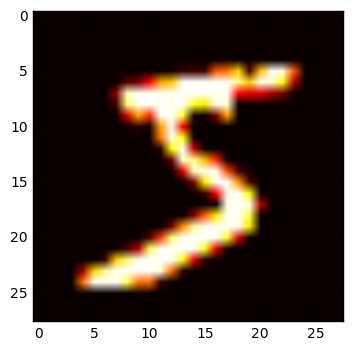

In [83]:
# Нарисуем картинку
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)

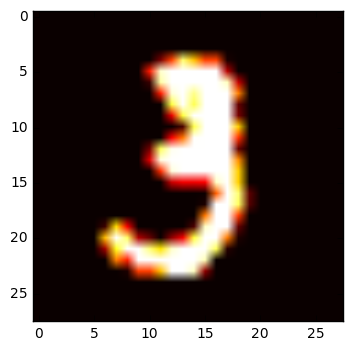

In [84]:
# Нарисуем еще одну
pylab.imshow(X_train[10, 0], cmap=pylab.cm.hot)

### Соберем нейросеть 

Мы хотим сделать нейросеть, которая будет принимать картинку (вектор 28 x 28) и сжимать ее в вектор длины 10 (к примеру). Нашим основным инструментом будет ```lasagne.layers.DenseLayer```. 

In [85]:
# Создадим теано переменные для объектов и ответов
input_x, target_x = T.tensor4("Input value",  dtype='float32'), T.tensor4("Target value", dtype='float32')

In [86]:
# Тут вам нужно собрать автоэнкодер, за вас написаны первый и последний слой,
# Нужно приделать к нему один или несколько средних

net = lasagne.layers.InputLayer((None, 1, 28, 28), input_x, name='Input') # Входной слой

#net = lasagne.layers.Conv2DLayer(net, num_filters=32, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.tanh)
net = lasagne.layers.MaxPool2DLayer(net, pool_size=(2, 2))

net = lasagne.layers.DenseLayer(net, 512)
net = lasagne.layers.DenseLayer(net, 384)
net = lasagne.layers.DenseLayer(net, 256)
net = lasagne.layers.DenseLayer(net, 192)
net = lasagne.layers.DenseLayer(net, 128)
net = lasagne.layers.DenseLayer(net, 96)
net = lasagne.layers.DenseLayer(net, 64)
net = lasagne.layers.DenseLayer(net, 48)
net = lasagne.layers.DenseLayer(net, 32)

mid = lasagne.layers.DenseLayer(net, 20)

net = lasagne.layers.DenseLayer(mid, 32)
net = lasagne.layers.DenseLayer(net, 48)
net = lasagne.layers.DenseLayer(net, 64)
net = lasagne.layers.DenseLayer(net, 96)
net = lasagne.layers.DenseLayer(net, 128)
net = lasagne.layers.DenseLayer(net, 192)
net = lasagne.layers.DenseLayer(net, 256)
net = lasagne.layers.DenseLayer(net, 384)
net = lasagne.layers.DenseLayer(net, 512)

net = lasagne.layers.DenseLayer(net, 28*28) # Последний слой
net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

In [87]:
# Получим предсказания от сети и определим функцию хорошести предсказания, как l2 норму
predict_train = lasagne.layers.get_output(net)
loss_train = lasagne.objectives.squared_error(predict_train, target_x).mean()

In [88]:
# Получим градиенты для обучения
weights = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss_train, weights, learning_rate=1e-4)

In [89]:
# Скомпилируем теано граф
train_func = theano.function([input_x, target_x], [loss_train], updates=updates, allow_input_downcast=True)
predi_func = theano.function([input_x], [predict_train], allow_input_downcast=True)
mid_func = theano.function([input_x], [lasagne.layers.get_output(mid)], allow_input_downcast=True)

### Обучим автоэнкодер

In [90]:
for i in range(20):
    loss, num_pass = 0, 0
    for (inputs, targets) in iterate_minibatches(X_train, X_train, 100, shuffle=True):
        loss += train_func(inputs, targets)[0]
        num_pass += 1  
    print 'epoch:', i, 'loss = ', loss/num_pass, 'ok' if loss/num_pass < 0.05 else 'need to add more layers'

epoch: 0 loss =  0.0790929258341 need to add more layers
epoch: 1 loss =  0.0652889709138 need to add more layers
epoch: 2 loss =  0.0511352943663 need to add more layers
epoch: 3 loss =  0.0443508112706 ok
epoch: 4 loss =  0.039526381205 ok
epoch: 5 loss =  0.0374698901432 ok
epoch: 6 loss =  0.036504668111 ok
epoch: 7 loss =  0.0357710934548 ok
epoch: 8 loss =  0.0350636342803 ok
epoch: 9 loss =  0.0344246387881 ok
epoch: 10 loss =  0.033771839982 ok
epoch: 11 loss =  0.0328340389295 ok
epoch: 12 loss =  0.0321207810295 ok
epoch: 13 loss =  0.0314724344573 ok
epoch: 14 loss =  0.0307919101447 ok
epoch: 15 loss =  0.030081193397 ok
epoch: 16 loss =  0.0291884963285 ok
epoch: 17 loss =  0.0285522645503 ok
epoch: 18 loss =  0.0280261010497 ok
epoch: 19 loss =  0.027560970755 ok


### Смотрим как мы научились востанавливать цифры

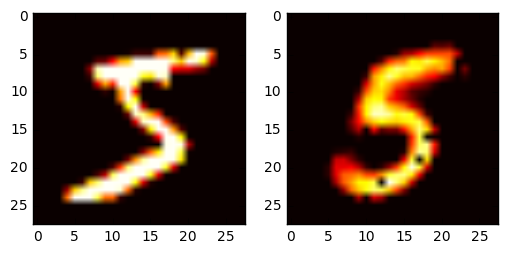

In [91]:
pylab.subplot(121)
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(predi_func(X_train[0, 0].reshape(1, 1, 28, 28))[0][0][0], cmap=pylab.cm.hot)

### Проецируем в 2d

Давайте теперь спроецируем ответы автоэнкодера в 2d c помощью метода tsne

In [92]:
from sklearn.manifold import TSNE

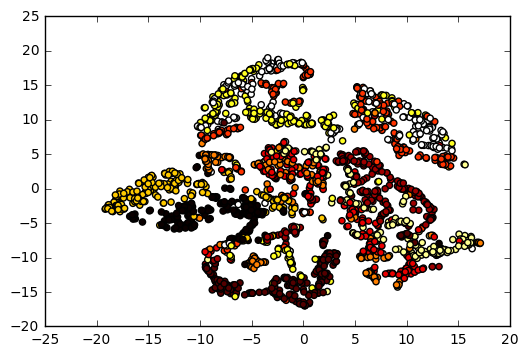

In [93]:
X_mid = mid_func(X_train)[0]
X_tsne = TSNE(n_components=2, n_iter=200).fit_transform(X_mid[:2000])
pylab.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[:2000], cmap=pylab.cm.hot)

### Сдача домашки

А теперь, чтобы сдать задание, вам нужно решить загадку. Мы (преподы) натренировали автоэнкодер, и показываем вам только выходы энкодера, очень хотим, чтобы вы натренировали декодер и прислали нам какие цифры изображены на некоторых картинках.

Раньше у вас была обучающая выборка из пар (Объект=Картинка, Ответ=Картинка), а теперь (Объект=маленький вектор, Ответ=Картинка). 

А теперь нужно заполнить гугл фому https://goo.gl/forms/GwTOpUkD20HEuDZv1.

**Нужно вводить ответы на цифры из теста!**
```python
y = X_test_mid
pylab.imshow(predi_func(y[idx].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)```

In [128]:
X_train_mid, y_train, X_test_mid = np.load('X_train_mid.npy'), X_train, np.load('X_test_mid.npy')

In [129]:
# В этой ячейке все тоже самое только нету части сети до mid слоя
# Вам нужно натренировать декодер
# Получить предсказания для теста (X_test_mid) и заслать решение не кегл

input_x, target_x = T.matrix("Input value",  dtype='float32'), T.tensor4("Target value", dtype='float32')
mid = lasagne.layers.InputLayer((None, 20), input_x, name='Input')

net = mid

net = lasagne.layers.DenseLayer(net, 32)
net = lasagne.layers.DenseLayer(net, 48)
net = lasagne.layers.DenseLayer(net, 64)
net = lasagne.layers.DenseLayer(net, 96)
net = lasagne.layers.DenseLayer(net, 128)
net = lasagne.layers.DenseLayer(net, 192)
net = lasagne.layers.DenseLayer(net, 256)
net = lasagne.layers.DenseLayer(net, 384)
net = lasagne.layers.DenseLayer(net, 512)
net = lasagne.layers.DenseLayer(net, 28*28)

net = lasagne.layers.ReshapeLayer(net, [[0], 1, 28, 28])

In [130]:
# Получим предсказания от сети и определим функцию хорошести предсказания, как l2 норму
predict_train = lasagne.layers.get_output(net)
loss_train = lasagne.objectives.squared_error(predict_train, target_x).mean()
# Получим градиенты для обучения
weights = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss_train, weights, learning_rate=1e-4)
# Скомпилируем теано граф
train_func = theano.function([input_x, target_x], [loss_train], updates=updates, allow_input_downcast=True)
predi_func = theano.function([input_x], [predict_train], allow_input_downcast=True)
mid_func = theano.function([input_x], [lasagne.layers.get_output(mid)], allow_input_downcast=True)

In [132]:
for i in range(1500):
    loss, num_pass = 0, 0
    for (inputs, targets) in iterate_minibatches(X_train_mid, X_train, 100, shuffle=True):
        loss += train_func(inputs, targets)[0]
        num_pass += 1  
    print 'epoch:', i, 'loss = ', loss/num_pass

epoch: 0 loss =  0.0206052978092
epoch: 1 loss =  0.0205479049109
epoch: 2 loss =  0.0204839017874
epoch: 3 loss =  0.0204246222248
epoch: 4 loss =  0.0203427107021
epoch: 5 loss =  0.0202545142367
epoch: 6 loss =  0.0202090502553
epoch: 7 loss =  0.0201566905723
epoch: 8 loss =  0.0201019923398
epoch: 9 loss =  0.0200686375666
epoch: 10 loss =  0.0200129382913
epoch: 11 loss =  0.0199621339265
epoch: 12 loss =  0.0199085902871
epoch: 13 loss =  0.0198771035977
epoch: 14 loss =  0.0198384607235
epoch: 15 loss =  0.0197973859218
epoch: 16 loss =  0.0197517292785
epoch: 17 loss =  0.0197172286626
epoch: 18 loss =  0.0196702316801
epoch: 19 loss =  0.0196381318136
epoch: 20 loss =  0.0196061700775
epoch: 21 loss =  0.0195643331589
epoch: 22 loss =  0.0195186687612
epoch: 23 loss =  0.019481825344
epoch: 24 loss =  0.0194392600172
epoch: 25 loss =  0.0194177266821
epoch: 26 loss =  0.0193824189427
epoch: 27 loss =  0.0193478342813
epoch: 28 loss =  0.0193133172577
epoch: 29 loss =  0.01928

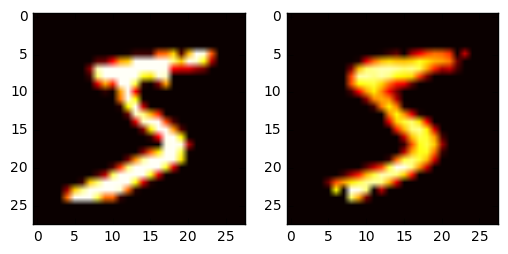

In [133]:
pylab.subplot(121)
pylab.imshow(X_train[0, 0], cmap=pylab.cm.hot)
pylab.subplot(122)
pylab.imshow(predi_func(X_train_mid[0].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)

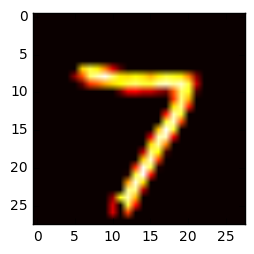

In [134]:
pylab.subplot(122)
pylab.imshow(predi_func(X_test_mid[0].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)

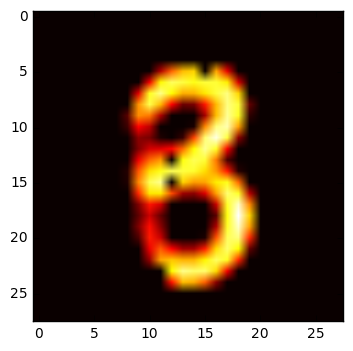

In [135]:
y = X_test_mid

idx = [681,2853,3136,1040,5693,6548,843,4890,6670,9153]


pylab.imshow(predi_func(y[idx[1]].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)



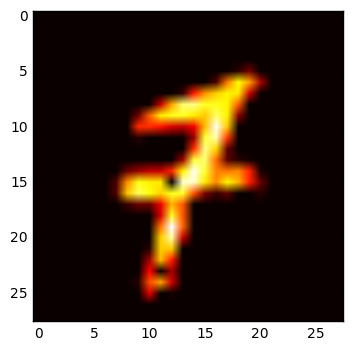

In [136]:
pylab.imshow(predi_func(y[idx[2]].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)


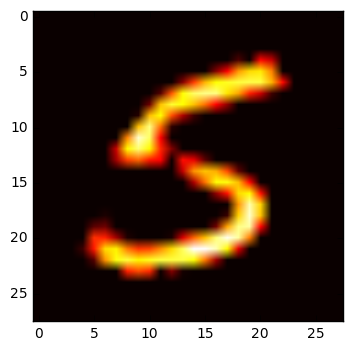

In [137]:
pylab.imshow(predi_func(y[idx[5]].reshape(1, 20))[0][0][0], cmap=pylab.cm.hot)